# Finetuning a Language Model to Predict Static Rankings

In this notebook, we'll attempt to finetune a pre-trained language model in the task of ranking prediction.
We'll use the CORD-19 dataset compiled by the Allen Institute for Artificial Intelligence, which comprehends more than 200.000 papers related to the Coronavirus pandemic.

We'll build the references graph and use the PageRank static ranking algorithm to assess the relevance of each paper.
Then, we'll put a classifier head on top of a pre-trained language model and finetune it using the ranking scores as supervision in a semi-supervised way.

## Building the references graph

Refer to the following notebooks to inspect the source code used to build the references graph.

- https://github.com/Inria-Chile/risotto/blob/master/01_references.ipynb
- https://github.com/Inria-Chile/risotto/blob/master/05_cook_artifacts.ipynb

In [ ]:
from google.colab import drive

drive.mount("/drive")

!ls -lart /drive/My\ Drive/RISOTTO/artifacts/

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
total 302093
-rw------- 1 root root 200066852 Jul 22 20:56 artifacts.hdf
-rw------- 1 root root 109275992 Aug  5 22:45 artifact.4.hdf


In [ ]:
!pip install -U pandas tables numpy transformers torch pytorch-lightning

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.0)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (3.0.2)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: pytorch-lightning in /usr/local/lib/python3.6/dist-packages (0.8.5)


In [ ]:
import pandas as pd
import numpy as np

ARTIFACTS_PATH = "/drive/My Drive/RISOTTO/artifacts/artifact.4.hdf"


def get_papers():
    papers = pd.read_hdf(ARTIFACTS_PATH, key="papers").fillna("N/A")
    papers["pagerank"] = np.log(papers["pagerank"])
    mean_pagerank = papers["pagerank"].mean()
    std_pagerank = papers["pagerank"].std()
    papers["pagerank"] = (papers["pagerank"] - mean_pagerank) / std_pagerank
    min_pagerank = papers["pagerank"].min()
    max_pagerank = papers["pagerank"].max()
    papers["pagerank"] = (papers["pagerank"] - min_pagerank) / (max_pagerank - min_pagerank)
    return papers

papers = get_papers()
display(papers.head())
papers.columns, papers.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pagerank,affiliation,country,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
cord_uid,,,,,,,,,,,,,,,,,,,,,
ug7v899j,NaN,,,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,1.14726e+07,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04 00:00:00,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,N/A,N/A,N/A,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,N/A
02tnwd4m,NaN,University of Alabama at Birmingham,USA,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,1.1668e+07,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15 00:00:00,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A
ejv2xln0,NaN,Washington University School of Medicine,USA,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,1.1668e+07,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25 00:00:00,"Crouch, Erika C",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A
2b73a28n,NaN,,,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,1.16869e+07,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22 00:00:00,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A
9785vg6d,NaN,National Institutes of Health (Laboratory of H...,USA,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,1.16869e+07,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11 00:00:00,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A


(Index(['pagerank', 'affiliation', 'country', 'sha', 'source_x', 'title', 'doi',
        'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors',
        'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files',
        'pmc_json_files', 'url', 's2_id'],
       dtype='object'), (62427, 21))

## Finetuning a pre--trained language model

We'll implement our model using PyTorch.
We'll use available pre-trained language models published in the HuggingFace's models repository.
Finally, we'll use the PyTorch Lightning framework to structure our project..

## Quick EDA

In order to better understand our data, we'll do a quick exploratory data analysis.
Particularly, we are interested in looking at the PageRank values distribution and the cumulative number of papers along the time axis.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pagerank, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


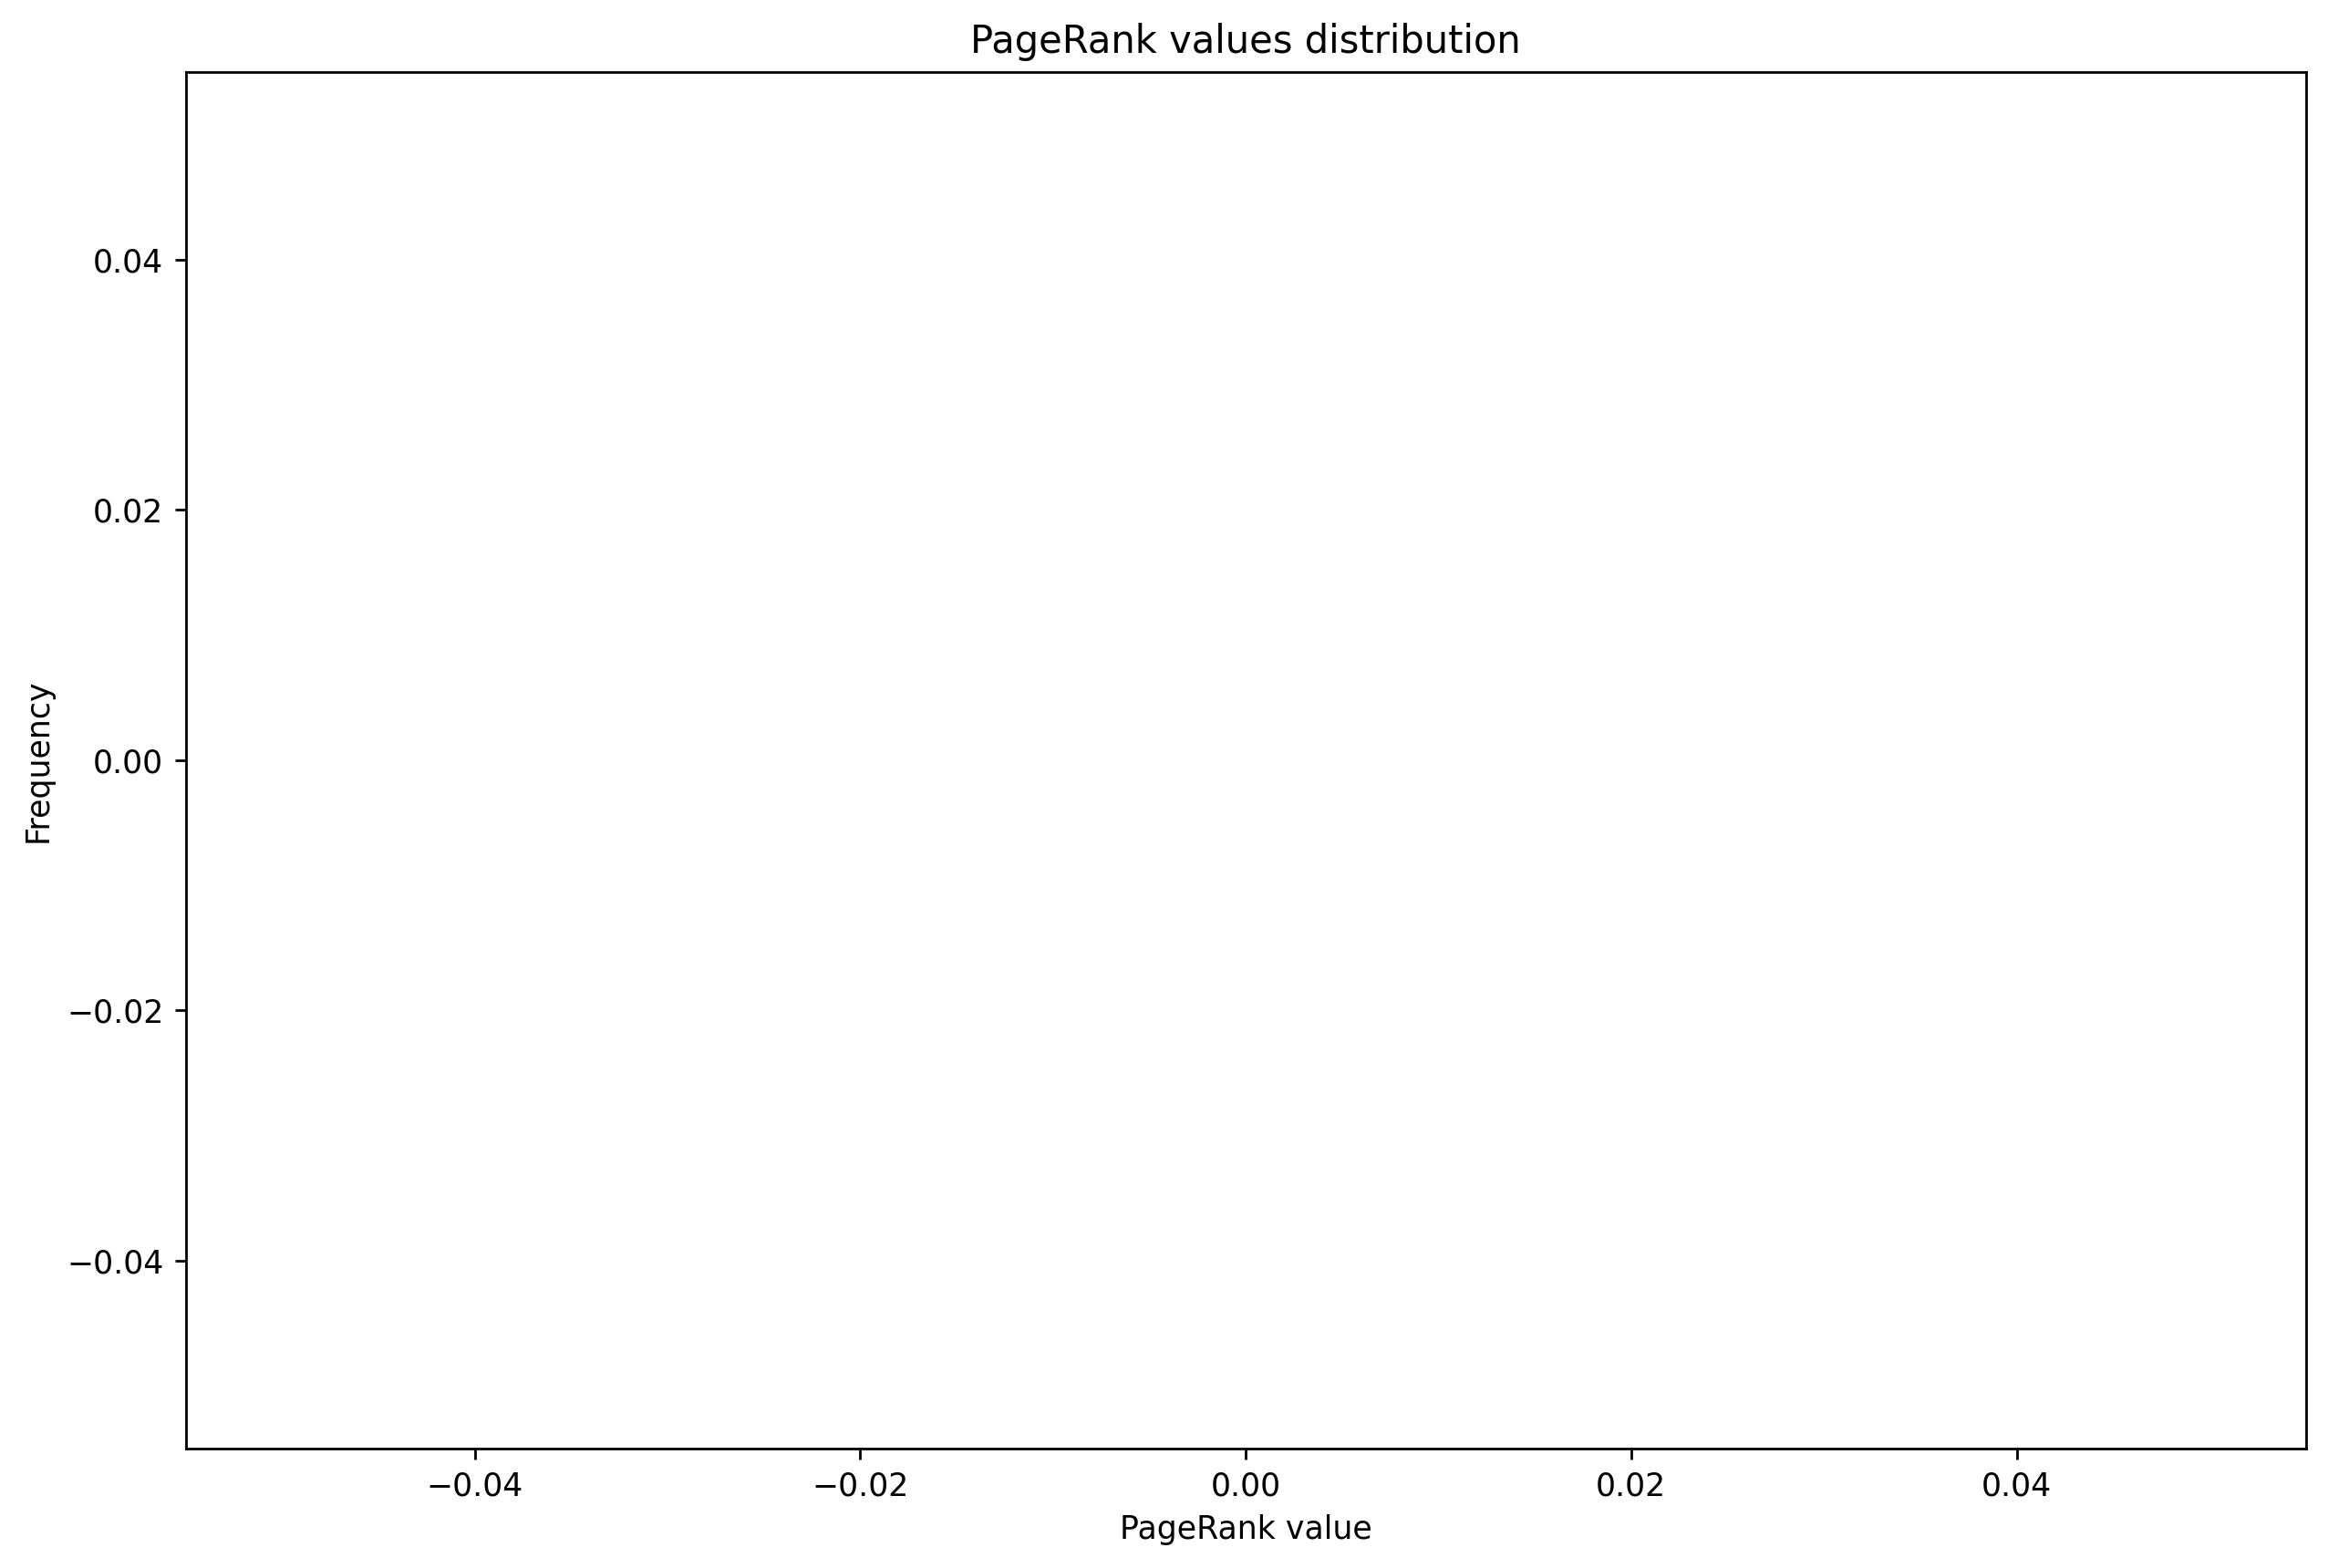

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


display(papers["pagerank"].describe())

fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.distplot(papers["pagerank"])
ax.set(
    title="PageRank values distribution",
    xlabel="PageRank value",
    ylabel="Frequency"
)

plt.show()

As expected, the PageRank values distribution is heavily skewed towards zero.

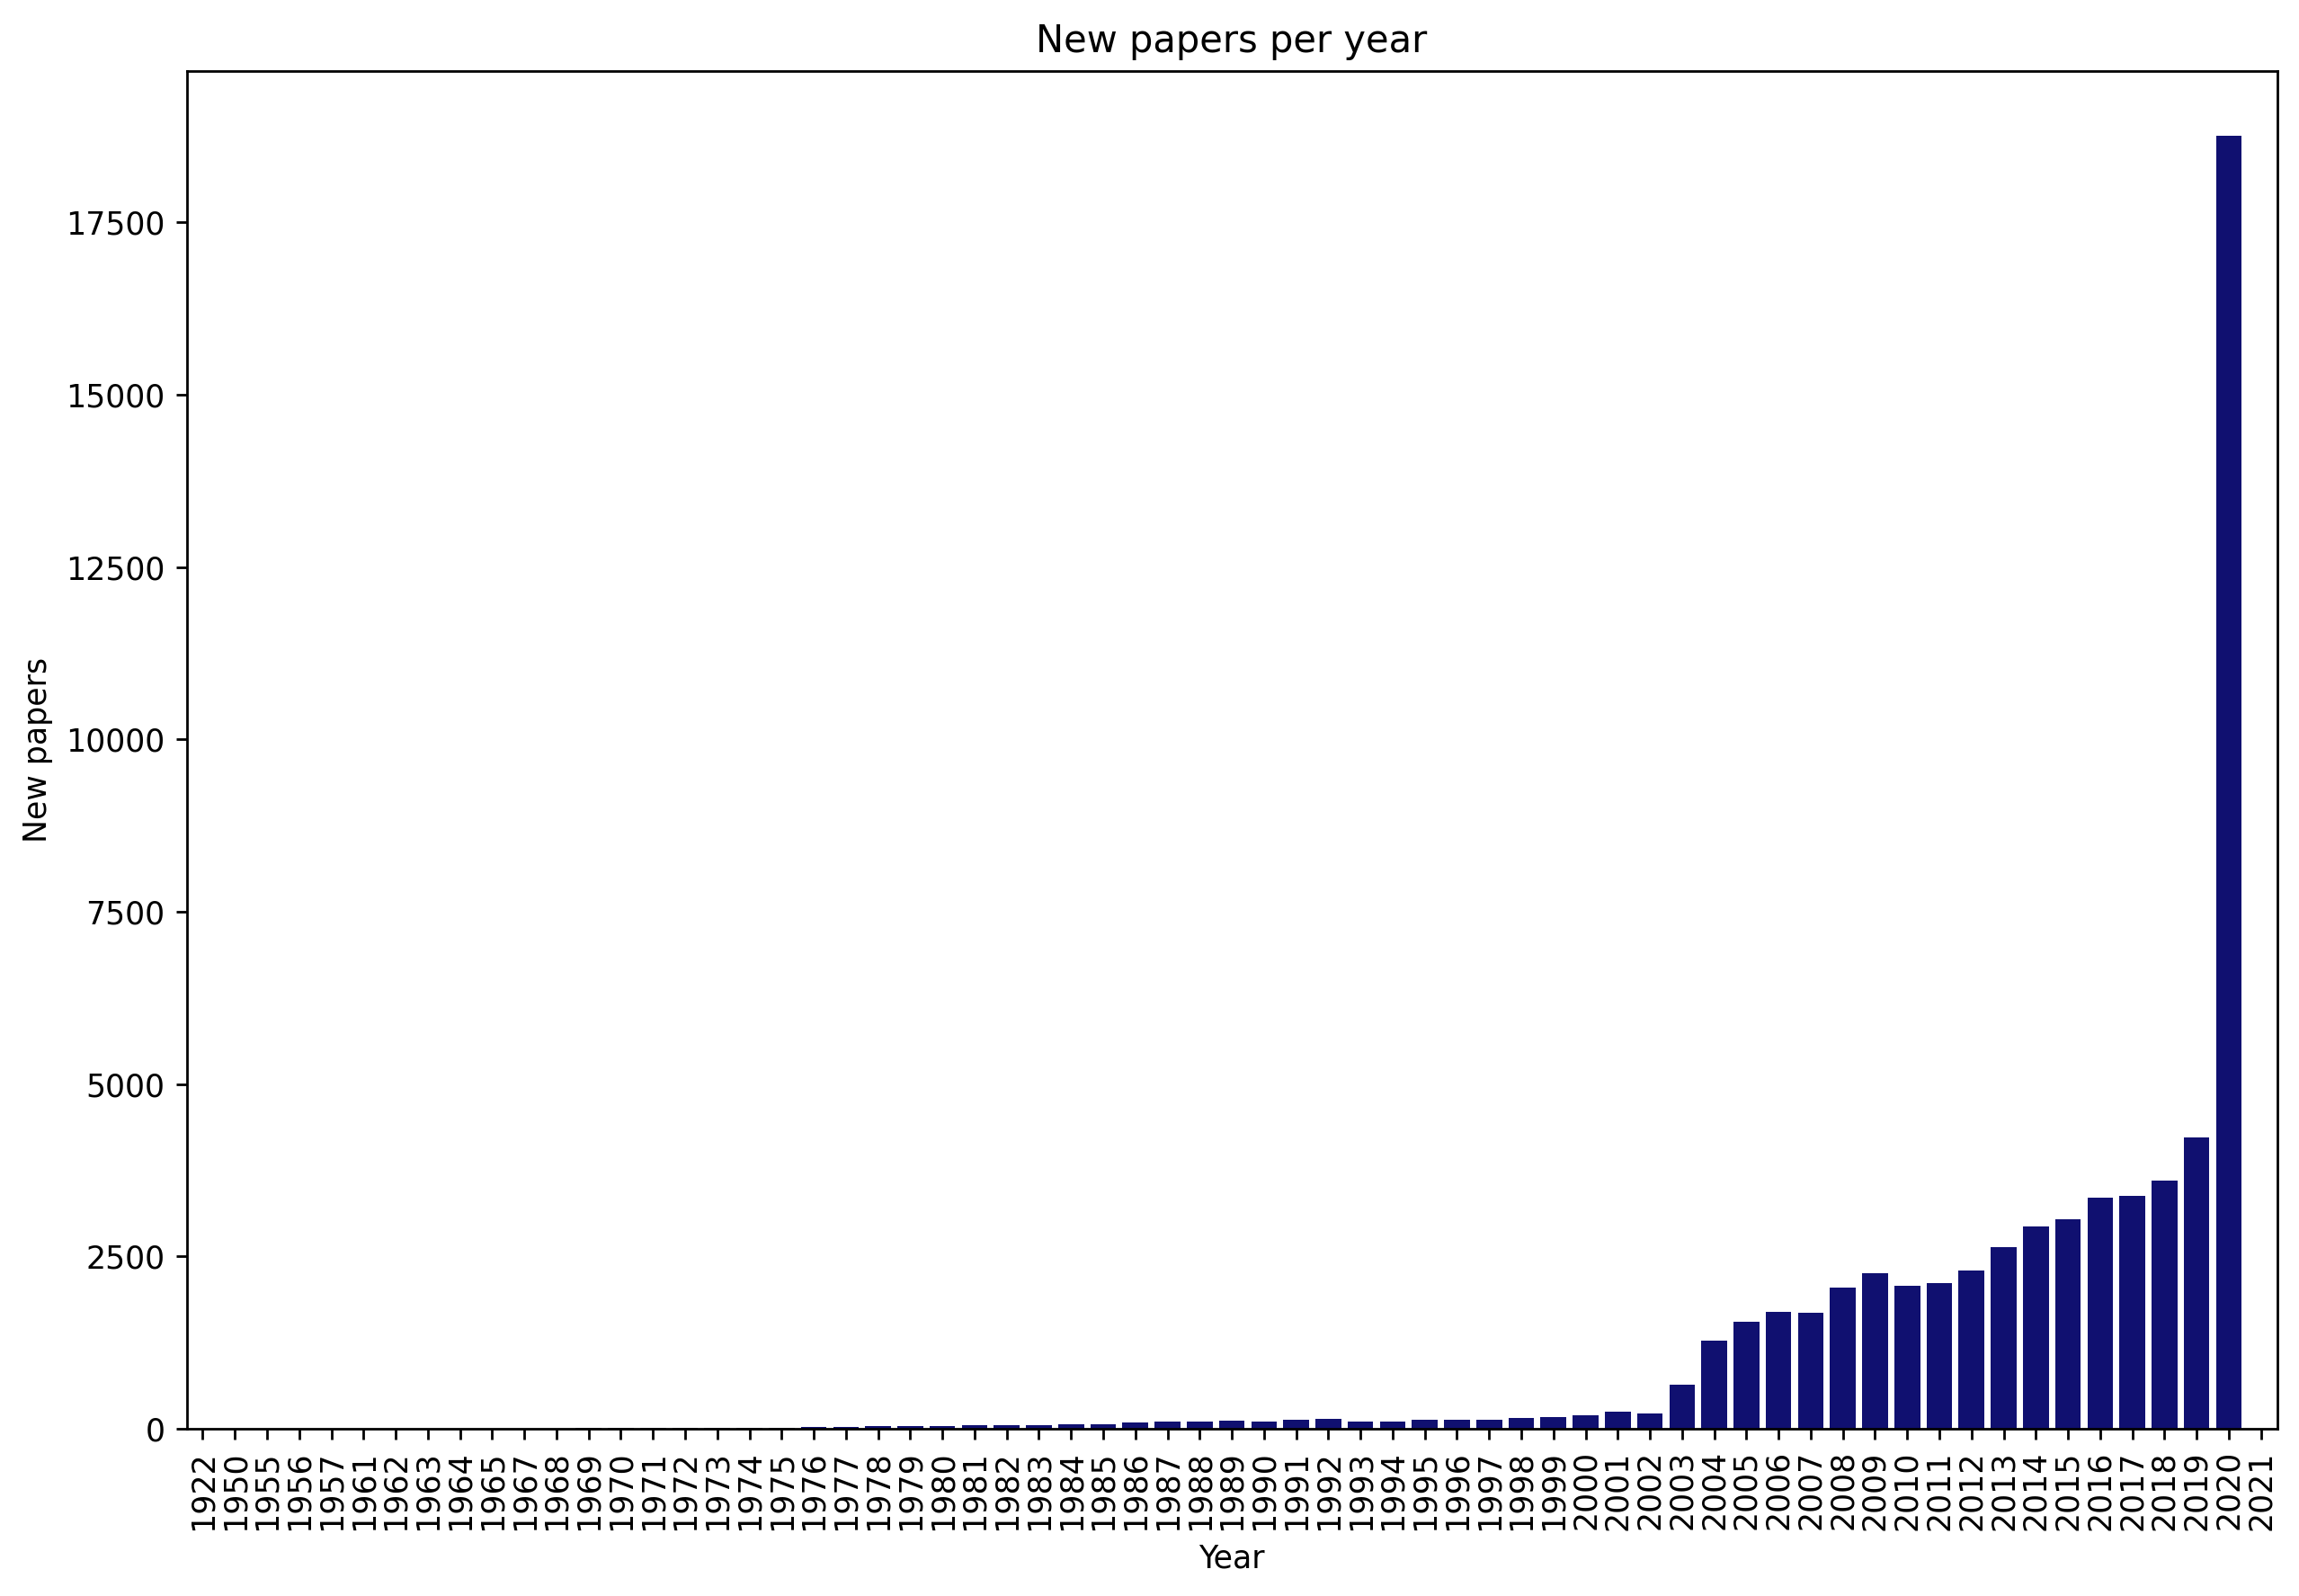

In [ ]:
papers["publish_time"] = pd.to_datetime(papers["publish_time"], errors="coerce")
papers_per_year = papers.groupby(papers["publish_time"].dt.year).size()

fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.barplot(x=papers_per_year.index.astype(int), y=papers_per_year, color=(0, 0, 0.5))
ax.set(
    title="New papers per year",
    xlabel="Year",
    ylabel="New papers",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

As expected, most of the dataset papers were published in recent years.

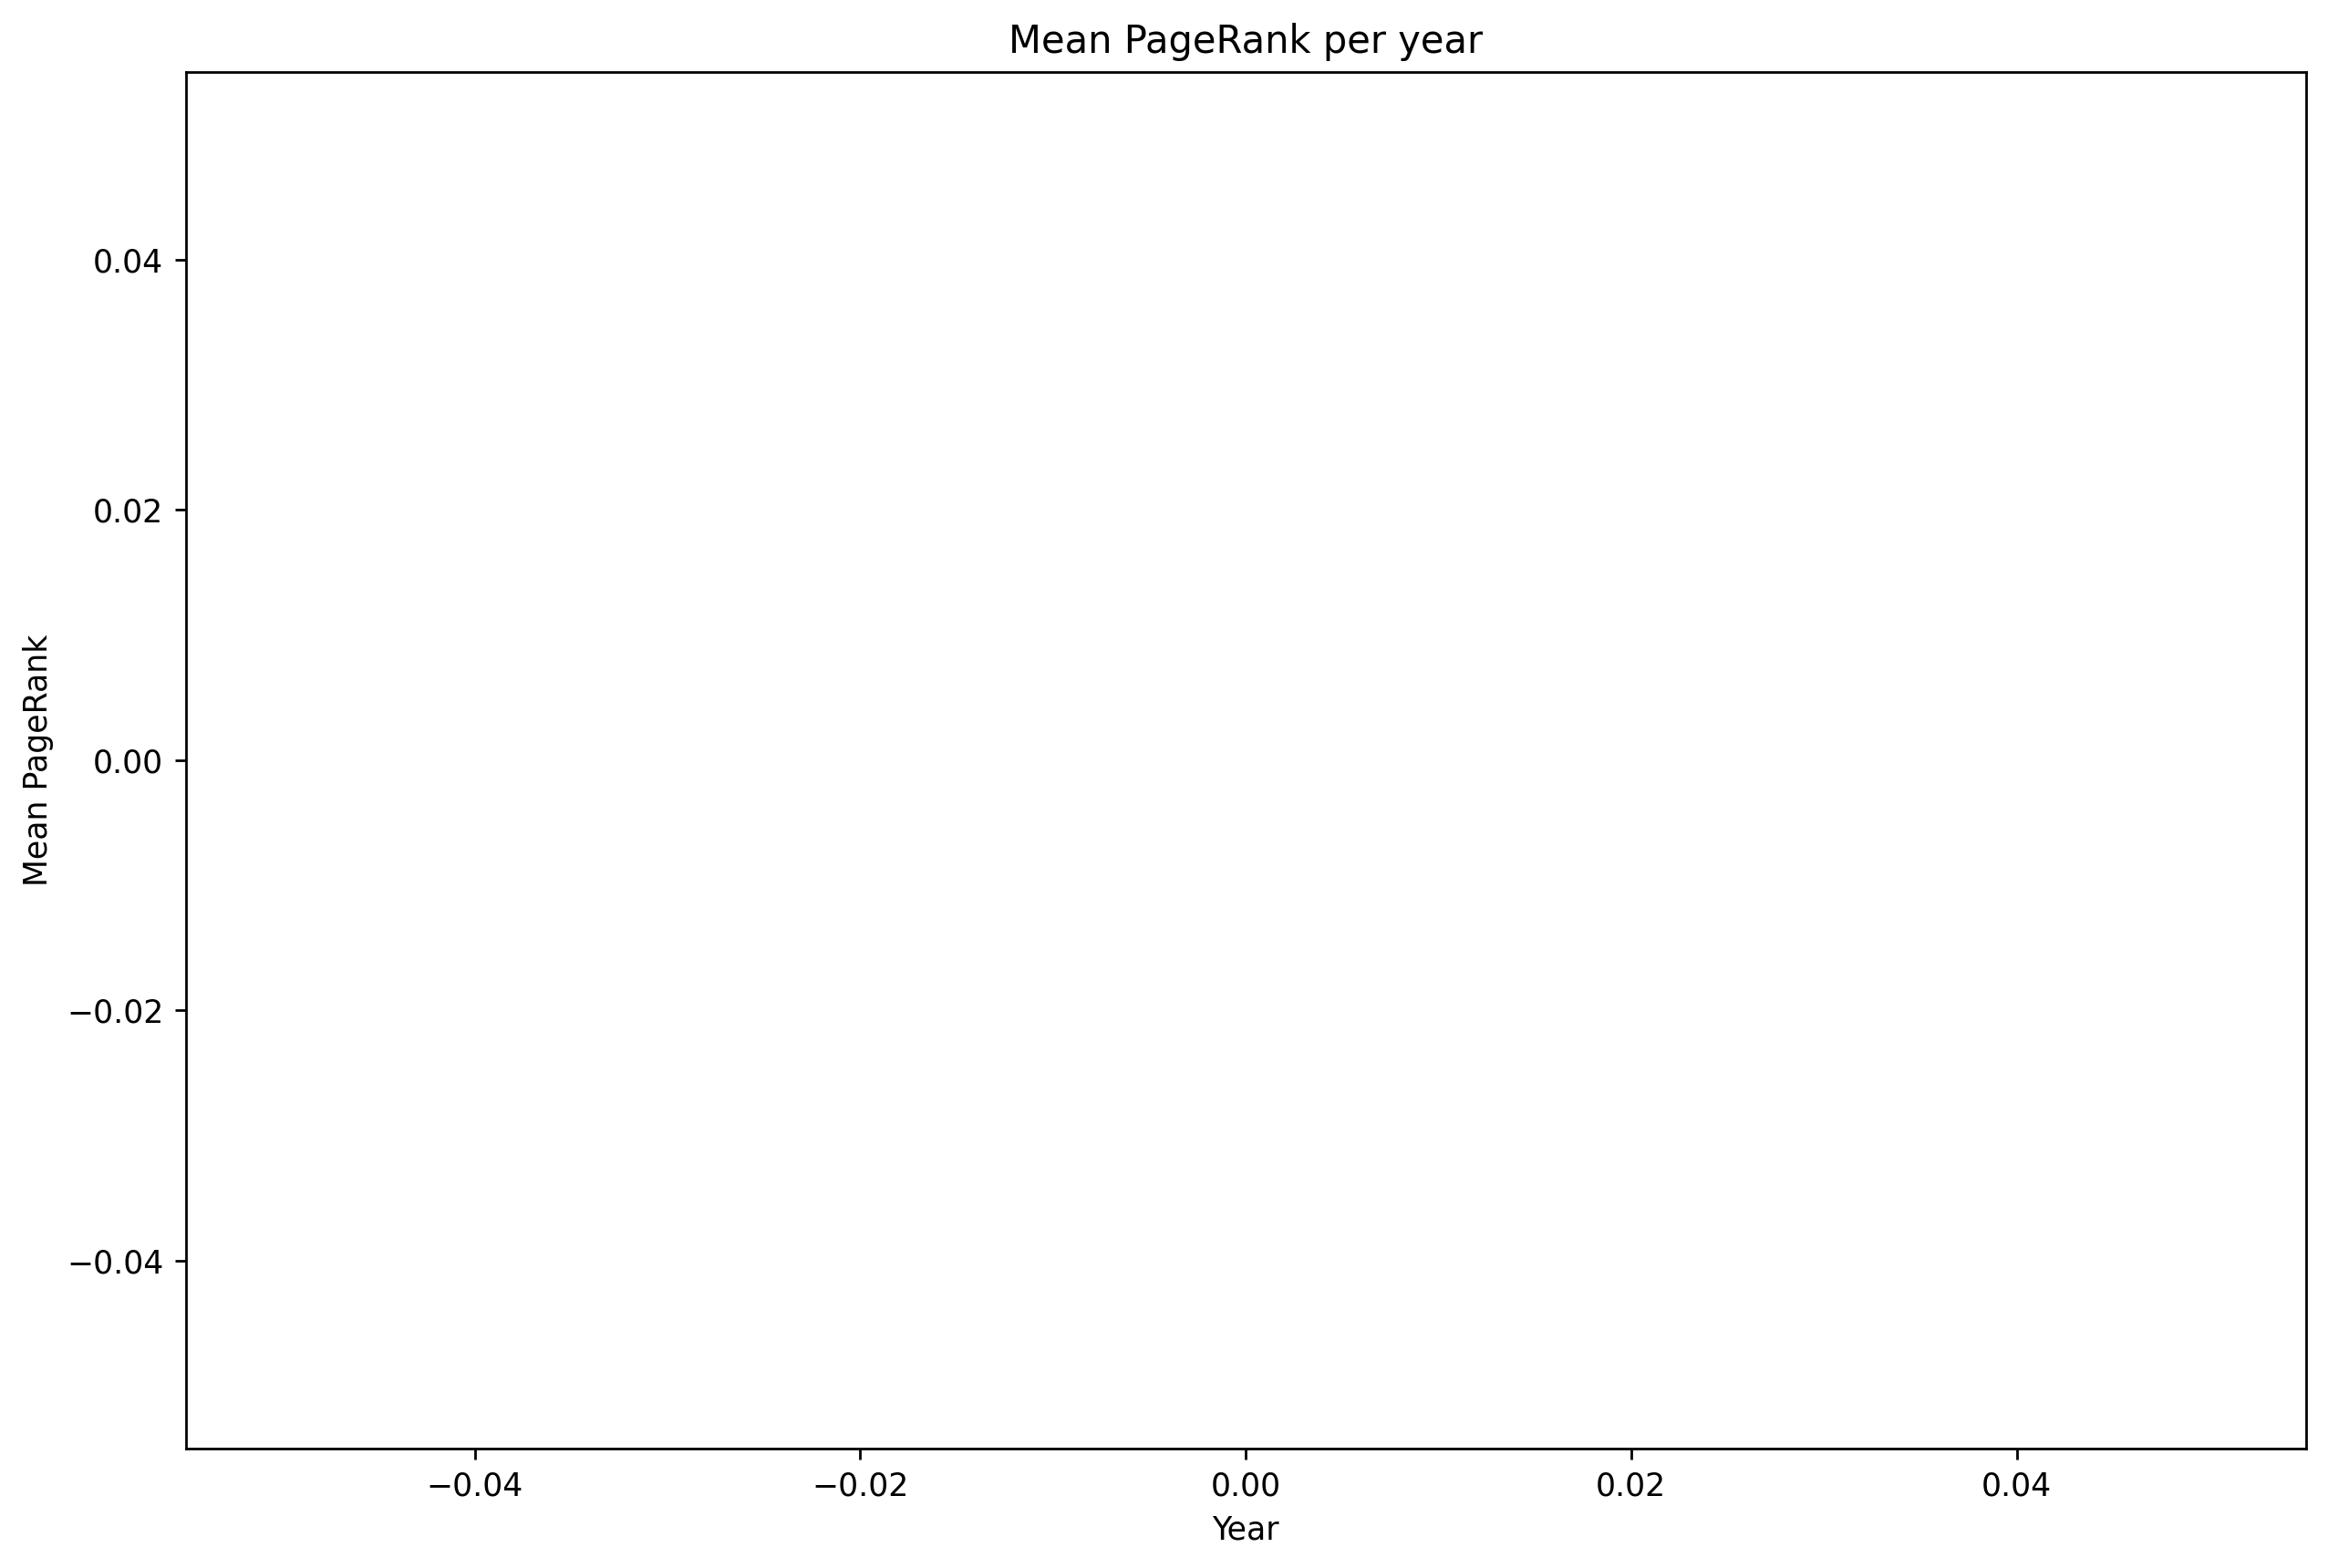

In [ ]:
pagerank_per_year = papers["pagerank"].groupby(papers["publish_time"].dt.year).mean()

fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.scatterplot(x=pagerank_per_year.index.astype(int), y=pagerank_per_year, color=(0, 0, 0.5))
ax.set(
    title="Mean PageRank per year",
    xlabel="Year",
    ylabel="Mean PageRank",
)

plt.show()

There's a slight negative correlation between the mean PageRank and the publication year from the 1970s until today.

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning import Trainer
from pytorch_lightning.core.lightning import LightningModule

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW


class PapersDataset(Dataset):
    def __init__(self, df):
        self._df = df
    
    def __getitem__(self, idx):
        item = self._df.iloc[idx]
        text = item["title"] + " " + item["abstract"]
        pagerank = item["pagerank"]
        return {
            "text": text,
            "pagerank": torch.tensor(pagerank, dtype=torch.float)
        }
    
    def __len__(self):
        return len(self._df)
        
        
class RankingPredictor(LightningModule):
    def __init__(self, base_model, learning_rate=1e-5):
        super().__init__()
        
        self.language_model = AutoModelForSequenceClassification.from_pretrained(base_model)
        self.tokenizer = AutoTokenizer.from_pretrained(base_model)
        
        self.learning_rate = learning_rate
        
    
    def forward(self, papers):
        papers_encoded = self.tokenizer(
            papers,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        input_ids = papers_encoded["input_ids"].to(self.device)
        attention_mask = papers_encoded["attention_mask"].to(self.device)
        outputs = self.language_model(input_ids, attention_mask=attention_mask)[0]
        return outputs
    
    def configure_optimizers(self):
        optimizer = AdamW(model.parameters(), lr=self.learning_rate)
        return optimizer
    
    def loss(self, predicted, target):
        predicted_activated = F.softmax(predicted, dim=1)
        predicted_sliced = predicted_activated[:,1].squeeze()
        mse = F.mse_loss(predicted_sliced, target)
        return mse
    
    def _inference(self, batch, _):
        text = batch["text"]
        target = batch["pagerank"]
        
        predicted = self(text)
        loss = self.loss(predicted, target)
        
        return {
            "loss": loss,
        }
    
    def training_step(self, batch, batch_idx):
        return self._inference(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx):
        return self._inference(batch, batch_idx)

In [ ]:
from sklearn.model_selection import train_test_split

# Training: 70%; Validation: 10%; Test: 20%
train_df, test_df = train_test_split(papers, train_size=0.8, test_size=0.2, random_state=2827)
train_df, val_df = train_test_split(train_df, train_size=0.875, test_size=0.125, random_state=2827)

train_ds = PapersDataset(train_df)
val_ds = PapersDataset(val_df)
test_ds = PapersDataset(test_df)

BATCH_SIZE = 16

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model = RankingPredictor("bert-base-uncased")

trainer = Trainer(
    gpus=1,
    overfit_pct=0.01,
    print_nan_grads=True,
)
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)
trainer.test(test_dataloaders=test_dl)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


MisconfigurationException: ignored

In [ ]:
# TODO:
# - Overfitear batch pequeño
# - Guardar peso
# - Armar script de Python y entrenar en algún cluster